# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e

# Wrangle

Data acquired from kaggle 
Each represints a show featured by Netflix

Columns not representing show descriptions or genres were dropped
A boolean column for each genre appearing in the "genres" column was added signifying if each show belonged to that genre

Rows containning blank descriptions were dropped
'Western' column was dropped do to low represintation (only 41 rows)

Data contains 5791 rows after being prepared 

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# get set of non-western genres
gen_set = e.get_gens(train)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")

Train set contains 3242 rows of data


# Explore

**1) Investigate data and choose a genre as a test case**

   * Test case should have a large represintation in the data
   * Test case should have a large number of unique words
   * Test case should have a large number of unique words per document

**How many shows are there of each genre?**

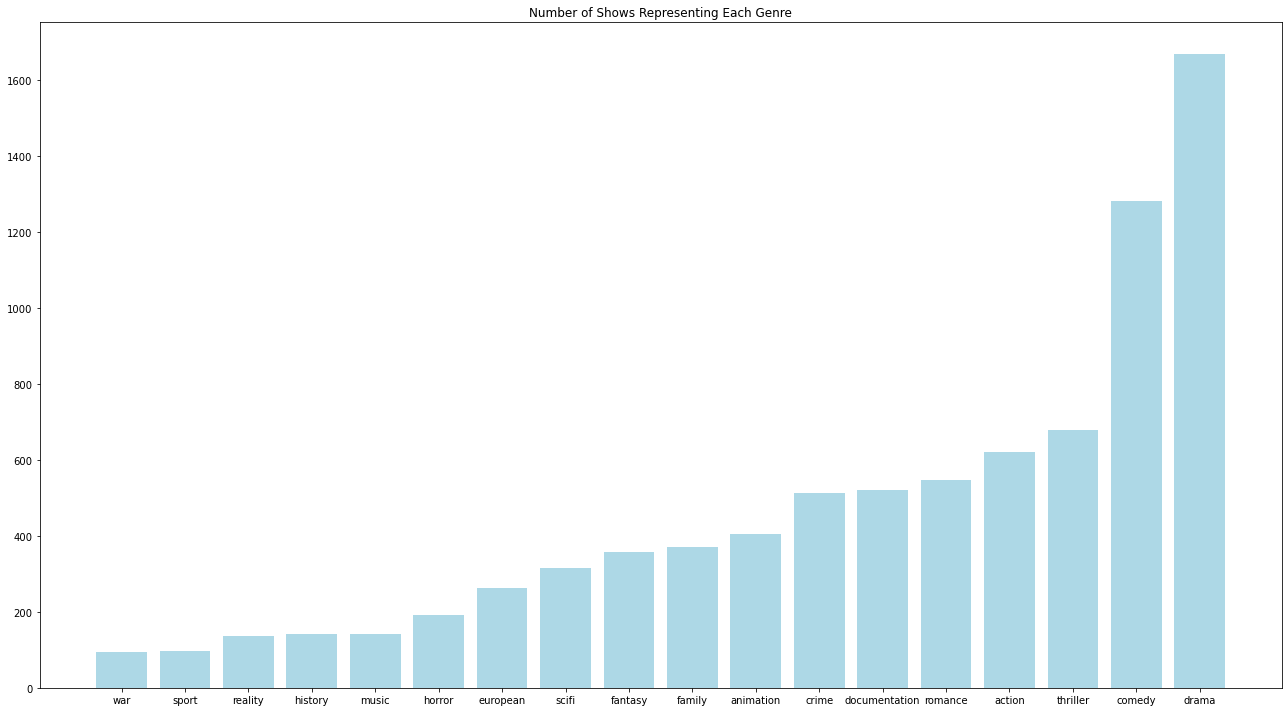

In [3]:
# get distribution of genres
e.shows_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners.

**How many words in each genre are unique words? (Appear only in descriptions of movies of that fall under that genre)**

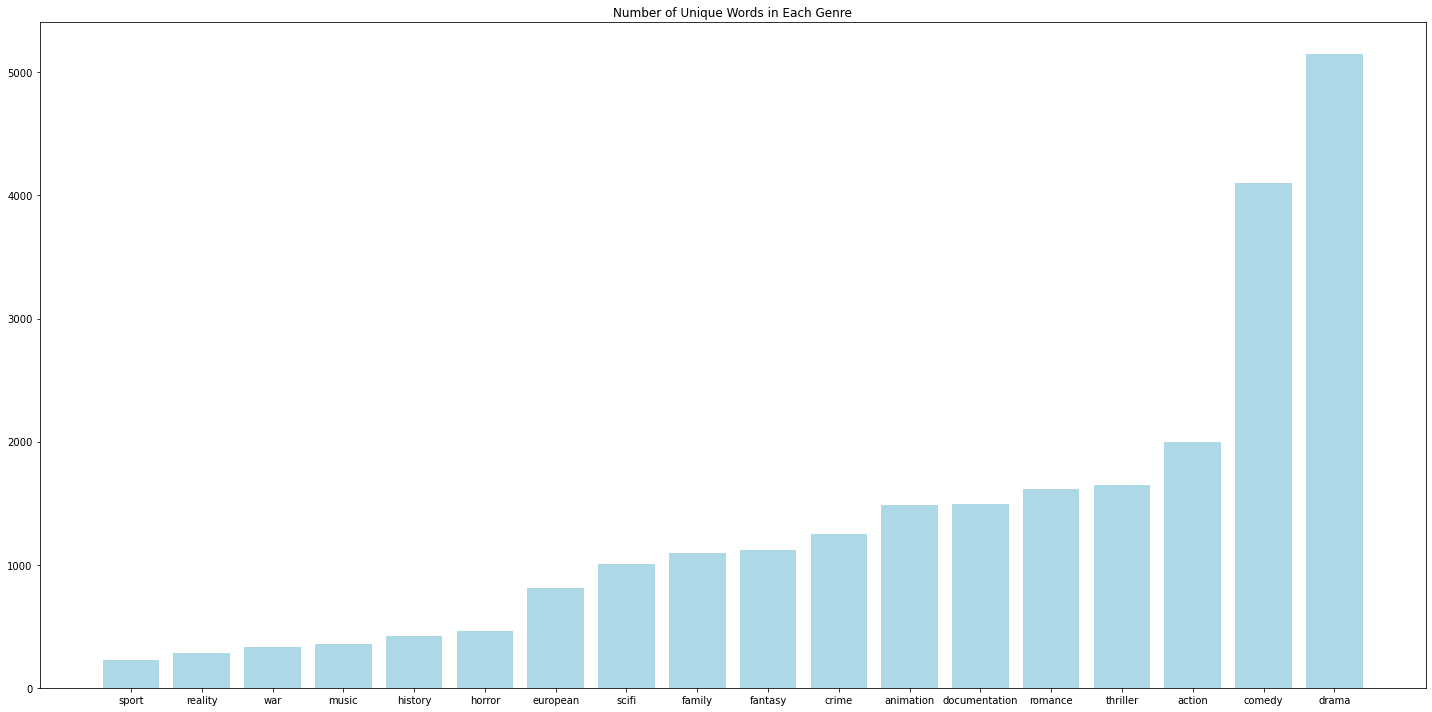

In [4]:
# get number of unique words fro each genre
e.unique_words_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners for unique words as well.

**How fequently do unique words appear in each genre?**

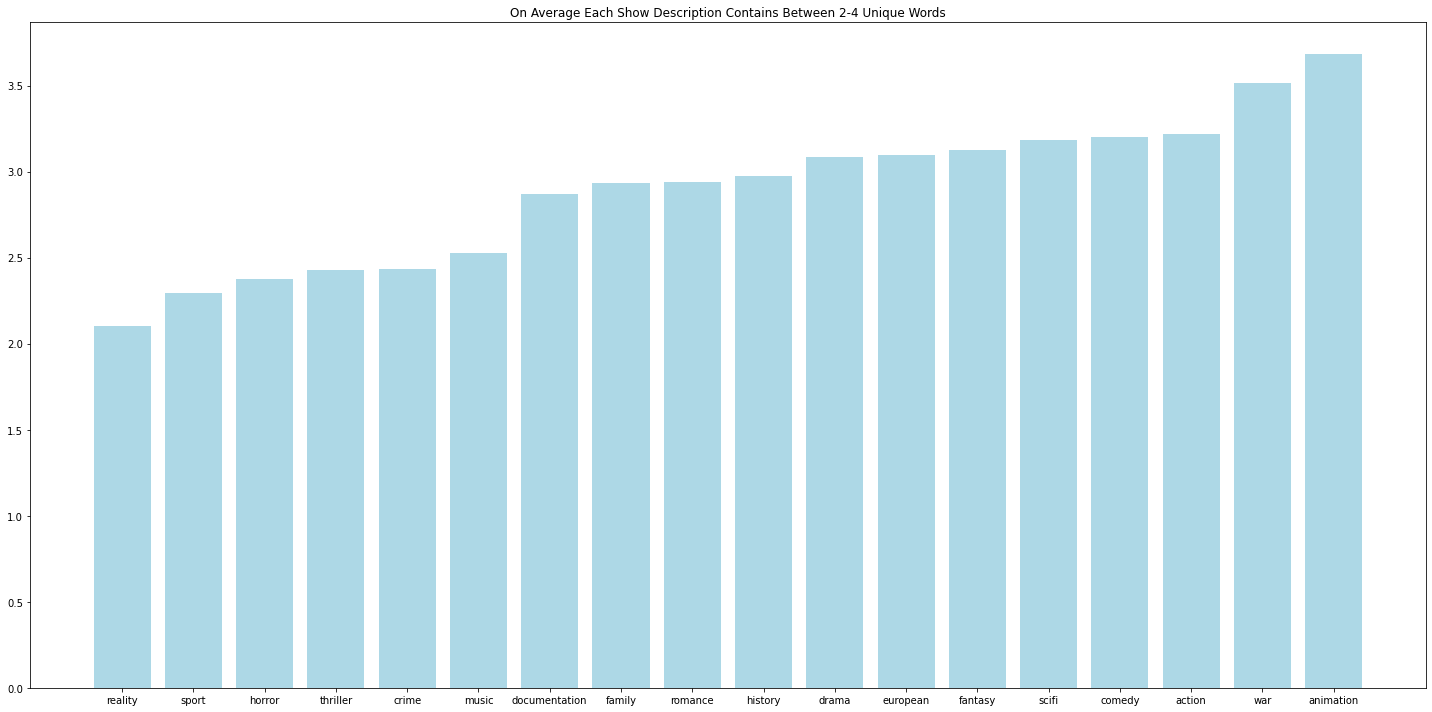

In [5]:
# get frequency of unique words pre genre
e.unique_words_frequency(train, gen_set)

Not a great deal of variance in unique word frequency. Comedy and Drama both have grater than three they were front runners in the other two criteria

**Comedy** and **Drama** have consistantly high values in all test criteria.
Comedy seems the less vague of the two genres, by human understanding. I will choose **Comedy** as my test case.

**2) Investigate test case (Comedy) and see how it compares to the rest of the data**

* What percent of the data is classified as a Comedy?
* Are there any words that appear more or less frequently across comedy or non-comedy show descriptions? <br>(Overall/by document)

In [6]:
train.head()

,description,genres,reality,drama,crime,romance,fantasy,music,action,comedy,european,documentation,sport,war,thriller,horror,history,family,scifi,animation
1880,crippling payday loan car cheat emission test ...,"[documentation, crime]",False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2007,filmmaker kip andersen uncovers secret prevent...,[documentation],False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
5829,azerbaijan layla indonesian scholar fall samir...,"[romance, drama]",False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2815,quebec impulsive headstrong nelly maloye novic...,"[animation, comedy]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
5218,hit hardwood east los angeles coach strong con...,"[documentation, sport]",False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False


In [8]:
train_set_of_words = set(train['description'].apply(lambda value : value.split(' ')).explode('description').to_list())
print("words", len(train_set_of_words))

comedy_word_list = train['description'][train.comedy == True].apply(lambda value : value.split(' ')).explode('description').to_list()
print("com words", len(comedy_word_list))

non_comedy_word_list = train['description'][train.comedy == False].apply(lambda value : value.split(' ')).explode('description').to_list()
print("non-com words", len(non_comedy_word_list))

words 14960
com words 29590
non-com words 43807


In [14]:
diff_list = []

word_rel_freq = {} 

comedy_train = train[train.comedy == True]

non_comedy_train = train[train.comedy == False]

In [20]:
len(comedy_train)

1282

In [36]:
freq_doc = {}
freq_count = {}

list_freq_doc = []
list_freq_count = []

In [37]:
for word in train_set_of_words:

        # get count of comedy films that have word in them
        comedy_train['com_count'] = comedy_train['description'].apply(lambda words: words.count(word))
        
        comedy_train['com_doc'] = comedy_train['com_count'] > 0
        
        c_w_count = comedy_train['com_count'].sum()
        
        c_d_count = comedy_train['com_doc'].sum()
        
        # get count of non-comedy films that have word in them
        non_comedy_train['non_count'] = non_comedy_train['description'].apply(lambda words: words.count(word))
        
        non_comedy_train['non_doc'] = non_comedy_train['non_count'] > 0
        
        n_w_count = non_comedy_train['non_count'].sum()
        
        n_d_count = non_comedy_train['non_doc'].sum()
        
        # subtract number of non-comedy films from number of comedy films
        
        w_total = c_w_count - n_w_count
        
        d_total = c_d_count - n_d_count
        
        # append difference
        
        freq_doc[f'{word}'] = d_total
        
        list_freq_doc.append(d_total)
        
        freq_count[f'{word}'] = w_total
        
        list_freq_count.append(w_total)

In [38]:
freq_doc

{'secondyear': -1,
 'unites': -1,
 'equal': -4,
 'garbage': -1,
 'hayatlar': 1,
 'bamboozled': 1,
 'raajneeti': -1,
 'playful': 1,
 'exemplary': -1,
 'kedibones': -1,
 'juncture': 1,
 'confront': -16,
 'tycoon': -1,
 'brash': 0,
 'shortfilm': 1,
 'romanticism': 1,
 'swath': -1,
 'protest': -4,
 'misdeed': -1,
 'classmate': -6,
 'pleads': 1,
 'tou': -17,
 'sensates': -1,
 'sung': 3,
 'latvian': 1,
 'derail': -1,
 'nationality': -1,
 'passenger': -5,
 'accountable': -1,
 'affronter': -1,
 'integrity': -2,
 'carral': -1,
 'refreshing': -1,
 'slew': -1,
 'revisit': -2,
 'lurks': -1,
 'stringer': -1,
 'boyka': -1,
 'ripped': -3,
 'fist': 0,
 'destigmatize': -1,
 'though': -1,
 'radhamusprime': 1,
 'engagement': 4,
 'prefer': 1,
 'furniture': -1,
 'disappearance': -10,
 'liu': -1,
 'protective': -2,
 'wary': 0,
 'natwarlal': -1,
 'nicotine': 1,
 'tant': -19,
 'feat': -9,
 'rose': -15,
 'apnea': 1,
 'resists': 1,
 'saturday': 2,
 'appliance': -1,
 'casey': -1,
 'bicycling': 1,
 'tamer': 2,
 '

In [39]:
list_freq_doc

[-1,
 -1,
 -4,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -16,
 -1,
 0,
 1,
 1,
 -1,
 -4,
 -1,
 -6,
 1,
 -17,
 -1,
 3,
 1,
 -1,
 -1,
 -5,
 -1,
 -1,
 -2,
 -1,
 -1,
 -1,
 -2,
 -1,
 -1,
 -1,
 -3,
 0,
 -1,
 -1,
 1,
 4,
 1,
 -1,
 -10,
 -1,
 -2,
 0,
 -1,
 1,
 -19,
 -9,
 -15,
 1,
 1,
 2,
 -1,
 -1,
 1,
 2,
 0,
 -1,
 0,
 1,
 1,
 -6,
 1,
 2,
 -1,
 1,
 -1,
 -3,
 -2,
 -1,
 -3,
 -2,
 -2,
 1,
 -7,
 0,
 -24,
 -5,
 1,
 -11,
 1,
 -3,
 3,
 -6,
 -1,
 4,
 -2,
 0,
 0,
 -1,
 -3,
 -1,
 0,
 9,
 -4,
 -8,
 -1,
 -1,
 -11,
 -3,
 2,
 -4,
 -1,
 -3,
 -13,
 -1,
 -1,
 -1,
 -11,
 -1,
 1,
 3,
 1,
 4,
 -2,
 -9,
 -6,
 -4,
 0,
 1,
 -1,
 -2,
 0,
 -5,
 -1,
 1,
 -1,
 -2,
 1,
 -1,
 -13,
 -1,
 0,
 -2,
 0,
 -1,
 -2,
 2,
 1,
 1,
 -3,
 14,
 -7,
 1,
 -1,
 -1,
 -3,
 -1,
 -1,
 1,
 7,
 -1,
 2,
 -59,
 -1,
 -3,
 -9,
 -515,
 -1,
 -1,
 -1,
 0,
 -4,
 23,
 -128,
 0,
 -6,
 -1,
 3,
 -2,
 -16,
 -6,
 -2,
 -1,
 1,
 1,
 0,
 -1,
 0,
 -1,
 3,
 1,
 1,
 1,
 -1,
 1,
 1,
 -13,
 0,
 -2,
 -1,
 0,
 -1,
 1,
 1,
 -1,
 -2,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 2,
 -2,
 0,
 

In [40]:
freq_count

{'secondyear': -1,
 'unites': -1,
 'equal': -4,
 'garbage': -1,
 'hayatlar': 1,
 'bamboozled': 1,
 'raajneeti': -1,
 'playful': 1,
 'exemplary': -1,
 'kedibones': -1,
 'juncture': 1,
 'confront': -16,
 'tycoon': -1,
 'brash': 0,
 'shortfilm': 1,
 'romanticism': 1,
 'swath': -1,
 'protest': -4,
 'misdeed': -1,
 'classmate': -6,
 'pleads': 1,
 'tou': -18,
 'sensates': -1,
 'sung': 4,
 'latvian': 1,
 'derail': -2,
 'nationality': -1,
 'passenger': -5,
 'accountable': -1,
 'affronter': -1,
 'integrity': -2,
 'carral': -1,
 'refreshing': -1,
 'slew': -1,
 'revisit': -2,
 'lurks': -1,
 'stringer': -1,
 'boyka': -2,
 'ripped': -3,
 'fist': 0,
 'destigmatize': -1,
 'though': -1,
 'radhamusprime': 1,
 'engagement': 4,
 'prefer': 1,
 'furniture': -1,
 'disappearance': -10,
 'liu': -1,
 'protective': -2,
 'wary': 0,
 'natwarlal': -1,
 'nicotine': 1,
 'tant': -19,
 'feat': -11,
 'rose': -17,
 'apnea': 1,
 'resists': 1,
 'saturday': 2,
 'appliance': -1,
 'casey': -2,
 'bicycling': 1,
 'tamer': 3,
 

In [41]:
list_freq_count

[-1,
 -1,
 -4,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -16,
 -1,
 0,
 1,
 1,
 -1,
 -4,
 -1,
 -6,
 1,
 -18,
 -1,
 4,
 1,
 -2,
 -1,
 -5,
 -1,
 -1,
 -2,
 -1,
 -1,
 -1,
 -2,
 -1,
 -1,
 -2,
 -3,
 0,
 -1,
 -1,
 1,
 4,
 1,
 -1,
 -10,
 -1,
 -2,
 0,
 -1,
 1,
 -19,
 -11,
 -17,
 1,
 1,
 2,
 -1,
 -2,
 1,
 3,
 0,
 -1,
 0,
 1,
 1,
 -6,
 0,
 2,
 -1,
 1,
 -1,
 -3,
 -2,
 -1,
 -3,
 -3,
 -2,
 1,
 -6,
 0,
 -26,
 -5,
 1,
 -11,
 1,
 -3,
 3,
 -6,
 -1,
 5,
 -2,
 -1,
 0,
 -1,
 -3,
 -1,
 0,
 11,
 -5,
 -8,
 -1,
 -1,
 -12,
 -3,
 2,
 -4,
 -1,
 -3,
 -13,
 -1,
 -1,
 -2,
 -11,
 -1,
 1,
 3,
 1,
 5,
 -2,
 -11,
 -7,
 -4,
 0,
 1,
 -1,
 -2,
 0,
 -5,
 -1,
 1,
 -1,
 -2,
 1,
 -1,
 -17,
 -1,
 0,
 -2,
 0,
 -1,
 -2,
 2,
 2,
 1,
 -4,
 16,
 -6,
 1,
 -1,
 -1,
 -3,
 -1,
 -1,
 2,
 -4,
 -1,
 4,
 -65,
 -1,
 -3,
 -6,
 -1551,
 -1,
 -1,
 -1,
 1,
 -5,
 24,
 -155,
 -1,
 1,
 -1,
 3,
 -2,
 -21,
 -6,
 -2,
 -1,
 1,
 1,
 0,
 -1,
 0,
 -1,
 2,
 1,
 1,
 1,
 -1,
 1,
 1,
 -14,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 -1,
 -2,
 -1,
 2,
 1,
 2,
 -1,
 -1,
 2,
 -2

AttributeError: 'list' object has no attribute 'hist'

In [ ]:
for word in train_sow:
    
    train_word = train[[train.description.apply(lambda value: word.isin(value))]]
    
com_desc

In [ ]:
com_bow = train[['description']].apply(lambda value: value.split(' ')).explode('description')

com_bow